# Issue Inspection - Linkage

# Prep

In [1]:
import yaml
import spacy
import numpy as np
import pandas as pd
from typing import *
from functools import partial
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

# load config
cfg = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
model = SentenceTransformer("multi-qa-mpnet-base-cos-v1")
nlp = spacy.load("en_core_web_sm")

def __dist__(A: np.ndarray, B: np.ndarray, n_segments: int, lamda: float = 0.5) -> float:
    # calculate normalized positional distance
    if lamda > 0:                                               # include position
        A_pos, B_pos = int(A[0]), int(B[0])
        pos_dist = abs(A_pos - B_pos)                           # integer [1, n_segments]
        pos_dist_norm = pos_dist / n_segments                   # float [0, 1]
        A_vec, B_vec = A[1:], B[1:]
    else:                                                       # exclude position
        pos_dist_norm = 0
        A_vec, B_vec = A, B

    # calculate normalized cosine distance
    cos_sim = np.dot(A_vec, B_vec) / (np.linalg.norm(A_vec) * np.linalg.norm(B_vec))
    cos_dist = 1 - cos_sim                                      # float [0, 2]
    cos_dist_norm = cos_dist / 2                                # float [0, 1]

    # calculate weighted average
    return lamda * pos_dist_norm + (1-lamda) * cos_dist_norm    # float [0, 1]

def split_sentences(doc: str):
    return [text.text.strip() for segment in doc.split("\n") for text in nlp(segment).sents]

def group_by_cluster(texts, labels):
    df = pd.DataFrame({"label": labels, "texts": texts})
    df = df.groupby("label")["texts"].apply(lambda x: '\n'.join(x)).reset_index()
    return df["texts"].tolist(), df["label"].tolist()

def log_clusters(texts, ids):
    for text, id in zip(texts, ids):
        print(id, text)
        print()

/home/renyi/miniconda3/envs/sc/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Example: Paper

Let's use "Attention is All You Need" paper as an example.

In [2]:
doc_attention = """Attention Is All You Need

Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.

1 Introduction

Recurrent neural networks, long short-term memory and gated recurrent neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and transduction problems such as language modeling and machine translation. Numerous efforts have since continued to push the boundaries of recurrent language models and encoder-decoder architectures.

Recurrent models typically factor computation along the symbol positions of the input and output sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden states ht, as a function of the previous hidden state ht−1 and the input for position t. This inherently sequential nature precludes parallelization within training examples, which becomes critical at longer sequence lengths, as memory constraints limit batching across examples. Recent work has achieved significant improvements in computational efficiency through factorization tricks and conditional computation, while also improving model performance in case of the latter. The fundamental constraint of sequential computation, however, remains.

Attention mechanisms have become an integral part of compelling sequence modeling and transduction models in various tasks, allowing modeling of dependencies without regard to their distance in the input or output sequences. In all but a few cases, however, such attention mechanisms are used in conjunction with a recurrent network.

In this work, we propose the Transformer, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output. The Transformer allows for significantly more parallelization and can reach a new state of the art in translation quality after being trained for as little as twelve hours on eight P100 GPUs.

2 Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU, ByteNet, and ConvS2S, all of which use convolutional neural networks as basic building blocks, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions. In the Transformer, this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention as described in section 3.2.

Self-attention, sometimes called intra-attention, is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment, and learning task-independent sentence representations.

End-to-end memory networks are based on a recurrent attention mechanism instead of sequence-aligned recurrence and have been shown to perform well on simple-language question answering and language modeling tasks.

To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate self-attention, and discuss its advantages over models such as Extended Neural GPU, ByteNet, and ConvS2S.

3 Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure. Here, the encoder maps an input sequence of symbol representations to a sequence of continuous representations. Given the continuous representations, the decoder then generates an output sequence of symbols one element at a time. At each step, the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder.

Encoder and Decoder Stacks

The encoder is composed of a stack of N = 6 identical layers. Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network. We employ a residual connection around each of the two sub-layers, followed by layer normalization. To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension dmodel = 512.

The decoder is also composed of a stack of N = 6 identical layers. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization. We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with the fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

Scaled Dot-Product Attention

The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the query with all keys, divide each by the square root of dk, and apply a softmax function to obtain the weights on the values. In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V. We compute the matrix of outputs as:

Attention(Q, K, V) = softmax(QK^T / sqrt(dk)) V

The two most commonly used attention functions are additive attention and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of 1/sqrt(dk). Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code. While for small values of dk the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of dk. We suspect that for large values of dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. To counteract this effect, we scale the dot products by 1/sqrt(dk).

Multi-Head Attention

Instead of performing a single attention function with dmodel-dimensional keys, values, and queries, we found it beneficial to linearly project the queries, keys, and values h times with different, learned linear projections to dk, dk, and dv dimensions, respectively. On each of these projected versions of queries, keys, and values, we then perform the attention function in parallel, yielding dv-dimensional output values. These are concatenated and once again projected, resulting in the final values. Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

In this work, we employ h = 8 parallel attention layers, or heads. For each of these, we use dk = dv = dmodel/h = 64. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.

Applications of Attention in our Model

The Transformer uses multi-head attention in three different ways:

- In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models.

- The encoder contains self-attention layers. In a self-attention layer, all of the keys, values, and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

- Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot-product attention by masking out (setting to −∞) all values in the input of the softmax which correspond to illegal connections.

Position-wise Feed-Forward Networks

In addition to attention sub

-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

Embeddings and Softmax

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension dmodel. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to. In the embedding layers, we multiply those weights by sqrt(dmodel).

Positional Encoding

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension dmodel as the embeddings so that the two can be summed. There are many choices of positional encodings, learned and fixed. In this work, we use sine and cosine functions of different frequencies.

4 Why Self-Attention

In this section, we compare various aspects of self-attention layers to the recurrent and convolutional layers commonly used for mapping one variable-length sequence of symbol representations to another sequence of equal length, such as a hidden layer in a typical sequence transduction encoder or decoder. Motivating our use of self-attention we consider three desiderata.

One is the total computational complexity per layer. Another is the amount of computation that can be parallelized, as measured by the minimum number of sequential operations required. The third is the path length between long-range dependencies in the network. Learning long-range dependencies is a key challenge in many sequence transduction tasks. One key factor affecting the ability to learn such dependencies is the length of the paths forward and backward signals have to traverse in the network. The shorter these paths between any combination of positions in the input and output sequences, the easier it is to learn long-range dependencies. Hence we also compare the maximum path length between any two input and output positions in networks composed of the different layer types.

A self-attention layer connects all positions with a constant number of sequentially executed operations, whereas a recurrent layer requires O(n) sequential operations. In terms of computational complexity, self-attention layers are faster than recurrent layers when the sequence length n is smaller than the representation dimensionality d, which is most often the case with sentence representations used by state-of-the-art models in machine translations, such as word-piece and byte-pair representations. To improve computational performance for tasks involving very long sequences, self-attention could be restricted to considering only a neighborhood of size r in the input sequence centered around the respective output position. This would increase the maximum path length to O(n/r). We plan to investigate this approach further in future work.

5 Training

Training Data and Batching

We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs. Sentences were encoded using byte-pair encoding, which has a shared source-target vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT 2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece vocabulary. Sentence pairs were batched together by approximate sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.

Hardware and Schedule

We trained our models on one machine with 8 NVIDIA P100 GPUs. For our base models using the hyperparameters described throughout the paper, each training step took about 0.4 seconds. We trained the base models for a total of 100,000 steps or 12 hours. For our big models, step time was 1.0 seconds. The big models were trained for 300,000 steps (3.5 days).

Optimizer

We used the Adam optimizer with β1 = 0.9, β2 = 0.98, and ϵ = 10^−9. We varied the learning rate over the course of training.

Regularization

We employ three types of regularization during training:

- Residual Dropout: We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of Pdrop = 0.1.
- Label Smoothing: During training, we employed label smoothing of value ϵls = 0.1. This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

6 Results

Machine Translation

On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big)) outperforms the best previously reported models (including ensembles) by more than 2.0 BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model surpasses all previously published models and ensembles, at a fraction of the training cost of any of the competitive models.

On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0, outperforming all of the previously published single models, at less than 1/4 the training cost of the previous state-of-the-art model. The Transformer (big) model trained for English-to-French used dropout rate Pdrop = 0.1, instead of 0.3.

For the base models, we used a single model obtained by averaging the last 5 checkpoints, which were written at 10-minute intervals. For the big models, we averaged the last 20 checkpoints. We used beam search with a beam size of 4 and length penalty α = 0.6. These hyperparameters were chosen after experimentation on the development set. We set the maximum output length during inference to input length + 50, but terminate early when possible.

Model Variations

To evaluate the importance of different components of the Transformer, we varied our base model in different ways, measuring the change in performance on English-to-German translation on the development set, newstest2013. We used beam search as described in the previous section, but no checkpoint averaging.

English Constituency Parsing

To evaluate if the Transformer can generalize to other tasks we performed experiments on English constituency parsing. This task presents specific challenges: the output is subject to strong structural constraints and is significantly longer than the input. Furthermore, RNN sequence-to-sequence models have not been able to attain state-of-the-art results in small-data regimes.

We trained a 4-layer transformer with dmodel = 1024 on the Wall Street Journal (WSJ) portion of the Penn Treebank, about 40K training sentences. We also trained it in a semi-supervised setting, using the larger high-confidence and BerkleyParser corpora from with approximately 17M sentences. We used a vocabulary of 16K tokens for the WSJ only setting and a vocabulary of 32K tokens for the semi-supervised setting.

Our results show that despite the lack of task-specific tuning, our model performs surprisingly well, yielding better results than all previously reported models with the exception of the Recurrent Neural Network Grammar.

In contrast to RNN sequence-to-sequence models, the Transformer outperforms the Berkeley-Parser even when training only on the WSJ training set of 40K sentences.

7 Conclusion

In this work, we presented the Transformer, the first sequence transduction model based entirely on attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention.

For translation tasks, the Transformer can be trained significantly faster than architectures based on recurrent or convolutional layers. On both WMT 2014 English-to-German and WMT 2014 English-to-French translation tasks, we achieve a new state of the art. In the former task, our best model outperforms even all previously reported ensembles.

We are excited about the future of attention-based models and plan to apply them to other tasks. We plan to extend the Transformer to problems involving input and output modalities other than text and to investigate local, restricted attention mechanisms to efficiently handle large inputs and outputs such as images, audio, and video. Making generation less sequential is another research goal of ours."""

### k-split

Here's the implementation for the old `k-split` cluster chunker. Note that the implementation only uses the default functions from `scipy` except the distance function.

In [3]:
def single_linkage_clustering_k_split(data: np.ndarray, lamda: float = 0., n_clusters: int = 10):
    metric = partial(__dist__, n_segments=len(data), lamda=lamda)
    distance_matrix = np.abs(pdist(data, metric=metric))
    linkage_matrix = linkage(distance_matrix, method='single')
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    return cluster_labels

def cluster_chunker_k_split(doc: str, doc_id: str, lamda: float = 0., n_clusters: int = 10):
    sents = split_sentences(doc)
    embs = model.encode(sents)
    if lamda > 0: embs = np.insert(embs, 0, range(len(embs)), axis=1)     # insert position in front of semantic embeddings
    labels = single_linkage_clustering_k_split(embs, n_clusters=n_clusters)
    texts, ids = group_by_cluster(sents, labels)
    ids = ["{}|{}".format(doc_id, cluster_id) for cluster_id in ids]
    return texts, ids

Here's the result of running scipy-based cluster chunker on "Attention is All You Need".

In [4]:
texts, ids = cluster_chunker_k_split(doc_attention, doc_id="doc0", n_clusters=10)
log_clusters(texts, ids)

doc0|1 Attention Is All You Need
The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder.
The best performing models also connect the encoder and decoder through an attention mechanism.
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train.
Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU.
On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the lit

As shown above, the chunk `doc0|1` is far too long, whereas other chunks are far too short, almost only a single sentence.

Before diving into the "why", let's first take a look at `k-preserve` as well.

### k-preserve

In [5]:
def single_linkage_clustering_k_preserve(data: np.ndarray, lamda: float = 0., min_samples: Optional[int] = None):
    if min_samples is None:
        min_samples = len(data) // 10 + 1
    if min_samples > len(data)/2:
        min_samples = len(data) // 10 + 1
    n_clusters = len(data)//min_samples      # k-preserve initializes with total number of segments as n_clusters

    # perform single-linkage clustering with n_clusters first
    metric = partial(__dist__, n_segments=len(data), lamda=lamda)
    distance_matrix = np.abs(pdist(data, metric=metric))
    linkage_matrix = linkage(distance_matrix, method='single')
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

    while True:
        # find the small clusters with less than min_samples
        unique_labels, counts = np.unique(cluster_labels, return_counts=True)
        small_clusters = unique_labels[counts < min_samples]
        small_counts = counts[counts < min_samples]

        # if no small clusters, break
        if len(small_clusters) == 0:
            break

        # find the smallest cluster to merge
        smallest_cluster = small_clusters[np.argmin(small_counts)]
        smallest_indices = np.where(cluster_labels == smallest_cluster)[0]

        # find the closest cluster to merge with
        min_distance = np.inf
        closest_cluster = None
        distance_square = squareform(distance_matrix)
        for i in smallest_indices:
            distances = distance_square[i]
            for lbl in unique_labels:
                if lbl != smallest_cluster:
                    cluster_indices = np.where(cluster_labels == lbl)[0]
                    mean_distance = np.mean(distances[cluster_indices])
                    if mean_distance < min_distance:
                        min_distance = mean_distance
                        closest_cluster = lbl

        # merge the smallest cluster with the closest cluster
        cluster_labels[cluster_labels == smallest_cluster] = closest_cluster

    # relabel clusters consecutively
    unique_labels = np.unique(cluster_labels)
    new_labels = np.zeros_like(cluster_labels)
    for new_label, unique_label in enumerate(unique_labels, start=1):
        new_labels[cluster_labels == unique_label] = new_label

    return new_labels

def cluster_chunker_k_preserve(doc: str, doc_id: str, lamda: float = 0., min_samples: Optional[int] = None):
    sents = split_sentences(doc)
    embs = model.encode(sents)
    if lamda > 0: embs = np.insert(embs, 0, range(len(embs)), axis=1)     # insert position in front of semantic embeddings
    labels = single_linkage_clustering_k_preserve(embs, lamda=lamda, min_samples=min_samples)
    texts, ids = group_by_cluster(sents, labels)
    ids = ["{}|{}".format(doc_id, cluster_id) for cluster_id in ids]
    return texts, ids

In [6]:
texts, ids = cluster_chunker_k_preserve(doc_attention, doc_id="doc0")
log_clusters(texts, ids)

doc0|1 Attention Is All You Need
Abstract
The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder.
The best performing models also connect the encoder and decoder through an attention mechanism.
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train.
Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU.
On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models fro

As shown above, when we do not set `min_samples`, the chunk `doc0|1` is the whole document, just like a `whole chunker`.

What happens if we set `min_samples`?

In [7]:
texts, ids = cluster_chunker_k_preserve(doc_attention, doc_id="doc0", min_samples=10)
log_clusters(texts, ids)

doc0|1 Attention Is All You Need
Abstract
The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder.
The best performing models also connect the encoder and decoder through an attention mechanism.
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train.
Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU.
On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models fro

Nothing. It's still the same as `whole chunker`.

Now. Let's take a look at the new version of single-linkage clustering.

### constrained single-linkage clustering

In [8]:
from encoder import get_encoder

def get_dist_mat(data: np.ndarray, lamda: float = 0.5) -> np.ndarray:
    return np.triu(squareform(np.abs(pdist(data, metric=partial(__dist__, n_segments=len(data), lamda=lamda)))))

def get_curr_min_idx(arr: np.ndarray):
    return np.argmin(arr)//len(arr), np.argmin(arr)%len(arr)

def single_linkage_clustering(embs: np.ndarray, lamda: float = 0.5, max_samples_per_cluster: Optional[int] = None):
    # get distance matrix
    dist_mat = get_dist_mat(embs, lamda=lamda)
    dist_mat[dist_mat == 0] = float('inf')  # set diagonal to infinity so that the minimum value can be iterated

    # set max_samples_per_cluster
    if not max_samples_per_cluster: max_samples_per_cluster = len(embs) // 10

    # initialize clusters and parents
    clusters = {i: [i] for i in range(len(embs))}
    parents = {i: i for i in range(len(embs))}

    # iterate through the distance matrix from min to max for single linkage clustering
    while dist_mat.min() < float('inf'):
        row, col = get_curr_min_idx(dist_mat)
        parent_row, parent_col = parents[row], parents[col]
        if parent_row != parent_col and len(clusters[parent_row]) + len(clusters[parent_col]) <= max_samples_per_cluster:
            clusters[parent_row].extend(clusters[parent_col])
            for sample in clusters[parent_col]:
                parents[sample] = parent_row
            del clusters[parent_col]
        dist_mat[row, col] = float('inf')

    # convert parents to cluster labels
    parent_to_cluster_label = {}
    temp_lbl = 0
    for parent in parents.values():
        if parent not in parent_to_cluster_label:
            parent_to_cluster_label[parent] = temp_lbl
            temp_lbl += 1

    # get cluster labels for all samples
    cluster_labels = [parent_to_cluster_label[parents[idx]] for idx in range(len(embs))]

    return cluster_labels

def cluster_chunker(doc, doc_id, encoder = None, lamda: float = 0., max_samples_per_cluster: Optional[int] = None):
    if not encoder: raise ValueError("Encoder is required for cluster_chunker")
    sents = split_sentences(doc)
    embs = encoder.embed_documents(sents)
    labels = single_linkage_clustering(embs, lamda=lamda, max_samples_per_cluster=max_samples_per_cluster)
    texts, ids = group_by_cluster(sents, labels)
    ids = ["{}|{}".format(doc_id, cluster_id) for cluster_id in ids]
    return texts, ids

In [9]:
texts, ids = cluster_chunker(doc_attention, doc_id="doc0", encoder=get_encoder("huggingface"))
log_clusters(texts, ids)

doc0|0 Attention Is All You Need
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
Attention mechanisms have become an integral part of compelling sequence modeling and transduction models in various tasks, allowing modeling of dependencies without regard to their distance in the input or output sequences.
In all but a few cases, however, such attention mechanisms are used in conjunction with a recurrent network.
In this work, we propose the Transformer, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output.
To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution.
Attention
An attention function can be described as mapping 

As shown above, the chunks have similar sample sizes and look much more consistent compared to the old methods.

Let's look at another example, randomly taken from the MLDR dataset.

## Example: MLDR

In [10]:
from dataloader import load_data
import random
random.seed(123)

corpus, _, _ = load_data("mldr")
key = random.choice(list(corpus.keys()))
doc_mldr = corpus[key]['text']
for line in doc_mldr.split("\n"):
    print(line)

The Negative Zone is a fictional setting, an antimatter universe appearing in American comic books published by Marvel Comics. The location is depicted in various publications from Marvel, most frequently in Fantastic Four and Captain Marvel. Created by Stan Lee and Jack Kirby, it first appeared in Fantastic Four #51 (June 1966).

Fictional description
The Negative Zone in the Marvel Universe is used as a fictional dimension. Essentially, it is a universe parallel to Earth's. The two have many similarities, but a few noteworthy differences include: all matter in the Negative Zone is negatively charged; the Negative Zone is entirely filled with a pressurized, breathable atmosphere; and near the center of the Negative Zone is a deadly vortex of unspeakable power. Since the Negative Zone is largely uninhabited, several would-be conquerors have attempted to bridge the gap to Earth and take over its population. A few notable residents of the Negative Zone include Blastaar and Annihilus.

Th

### k-split

In [11]:
texts, ids = cluster_chunker_k_split(doc_mldr, doc_id="doc0", n_clusters=10)
log_clusters(texts, ids)

doc0|1 In other media
Television
Film

doc0|2 Video games

doc0|3 See also
References
External links

doc0|4 The Negative Zone is a fictional setting, an antimatter universe appearing in American comic books published by Marvel Comics.
The location is depicted in various publications from Marvel, most frequently in Fantastic Four and Captain Marvel.
Created by Stan Lee and Jack Kirby, it first appeared in Fantastic Four #51 (June 1966).
The Negative Zone in the Marvel Universe is used as a fictional dimension.
Essentially, it is a universe parallel to Earth's.
The two have many similarities, but a few noteworthy differences include: all matter in the Negative Zone is negatively charged; the Negative Zone is entirely filled with a pressurized, breathable atmosphere; and near the center of the Negative Zone is a deadly vortex of unspeakable power.
Since the Negative Zone is largely uninhabited, several would-be conquerors have attempted to bridge the gap to Earth and take over its popula

### k-preserve

In [12]:
texts, ids = cluster_chunker_k_preserve(doc_mldr, doc_id="doc0", min_samples=10)
log_clusters(texts, ids)

doc0|1 Fictional description
They exchanged places by clasping the special bracelets each wore or automatically after a few hours.
History
Discovery
It is very clean, with sanitation, but extremely heavily guarded, including password-changes every ten minutes.
Unique features
This effect only lasts as long as the field is activated and, once closed, becomes invisible again.
Life
Time
Tarsuu –
Other versions
In other media
Television
Film
Video games
See also
Qward
References
External links

doc0|2 The Negative Zone is a fictional setting, an antimatter universe appearing in American comic books published by Marvel Comics.
The location is depicted in various publications from Marvel, most frequently in Fantastic Four and Captain Marvel.
Created by Stan Lee and Jack Kirby, it first appeared in Fantastic Four #51 (June 1966).
The Negative Zone in the Marvel Universe is used as a fictional dimension.
Essentially, it is a universe parallel to Earth's.
The two have many similarities, but a f

### constrained single-linkage clustering

In [13]:
texts, ids = cluster_chunker(doc_mldr, doc_id="doc0", encoder=get_encoder("huggingface"))
log_clusters(texts, ids)

doc0|0 The Negative Zone is a fictional setting, an antimatter universe appearing in American comic books published by Marvel Comics.
A few notable residents of the Negative Zone include Blastaar and Annihilus.
The Negative Zone is often visited by the Fantastic Four as Mister Fantastic discovered it, and has mapped portions of it extensively.
The Age of Apocalypse version of Blink also visited it once, which proved that there's only one Negative Zone, as Annihilus remembered the Fantastic Four even though they never existed in the Age of Apocalypse.
The Negative Zone is used to dispose of Earth-616's Galactus when he is accidentally transferred to the Ultimate Marvel universe due to the temporal distortions caused by the events of Age of Ultron.
The heroes of the Ultimate Marvel universe reasoned that Galactus will starve to death in the Negative Zone because it is a universe made of antimatter and Galactus would not have anything to eat there.
Most of the encounters heroes have had w

## Example: BEIR

In [14]:
corpus, _, _ = load_data("scidocs")
key = random.choice(list(corpus.keys()))
doc_beir = corpus[key]['text']
for line in doc_beir.split("\n"):
    print(line)

100%|██████████| 25657/25657 [00:00<00:00, 47568.96it/s]

Crowd detection and management using cascade classifier on ARMv8 and OpenCV-Python.
The steady increase in population and overcrowding has become an unavoidable factor in any public gathering or on the street during any festive occasions. The intelligent monitoring technology has been developing in recent years and human tracking has made a lot of progress. In this paper, we propose a method to manage the crowd by keeping in track the count of the people in the scene. In our study, we develop a system using Raspberry Pi 3 board that consists of ARMv8 CPU that detects the human heads and provide a count of humans in the region using OpenCV-Python. A Haar cascade classifier is trained for human head detection. Human tracking is achieved by indicating the direction of movement of the person. The results of the analysis will be helpful in managing the crowd in any area with high density of crowds.
Self-Adaptive Skin Segmentation in Color Images.
In this paper, we present a new method for s

### k-split

In [15]:
texts, ids = cluster_chunker_k_split(doc_beir, doc_id="doc0", n_clusters=10)
log_clusters(texts, ids)

doc0|1 Exploiting the Data Redundancy Locality to Improve the Performance of Deduplication-Based Storage Systems.
The chunk-lookup disk bottleneck and the read amplification problems are two great challenges for deduplication-based storage systems and restrict the applicability of data deduplication for large-scale data volumes.
Previous studies and our experimental evaluations have shown that the amount of redundant data shared among different types of applications is negligible.
Based on the observations, we propose AA-Plus which effectively groups the hash index of the same application together and divides the whole hash index into different groups based on the application types.
Moreover, it groups the data chunks of the same application together on the disks.
The extensive trace-driven experiments conducted on our lightweight prototype implementation of AA-Plus show that compared with AA-Dedupe, AA-Plus significantly speeds up the write throughput by a factor of up to 6.9 and with

### k-preserve

In [16]:
texts, ids = cluster_chunker_k_preserve(doc_beir, doc_id="doc0", min_samples=10)
log_clusters(texts, ids)

doc0|1 Crowd detection and management using cascade classifier on ARMv8 and OpenCV-Python.
The steady increase in population and overcrowding has become an unavoidable factor in any public gathering or on the street during any festive occasions.
The intelligent monitoring technology has been developing in recent years and human tracking has made a lot of progress.
In this paper, we propose a method to manage the crowd by keeping in track the count of the people in the scene.
In our study, we develop a system using Raspberry Pi 3 board that consists of ARMv8 CPU that detects the human heads and provide a count of humans in the region using OpenCV-Python.
A Haar cascade classifier is trained for human head detection.
Human tracking is achieved by indicating the direction of movement of the person.
The results of the analysis will be helpful in managing the crowd in any area with high density of crowds.
Self-Adaptive Skin Segmentation in Color Images.
In this paper, we present a new metho

### constrained single-linkage clustering

In [17]:
texts, ids = cluster_chunker(doc_beir, doc_id="doc0", encoder=get_encoder("huggingface"))
log_clusters(texts, ids)

doc0|0 Crowd detection and management using cascade classifier on ARMv8 and OpenCV-Python.
The intelligent monitoring technology has been developing in recent years and human tracking has made a lot of progress.
In our study, we develop a system using Raspberry Pi 3 board that consists of ARMv8 CPU that detects the human heads and provide a count of humans in the region using OpenCV-Python.
A Haar cascade classifier is trained for human head detection.
Human tracking is achieved by indicating the direction of movement of the person.

doc0|1 The steady increase in population and overcrowding has become an unavoidable factor in any public gathering or on the street during any festive occasions.
In this paper, we propose a method to manage the crowd by keeping in track the count of the people in the scene.
The results of the analysis will be helpful in managing the crowd in any area with high density of crowds.
OBJECTIVE
PARTICIPANTS
INTERVENTIONS
MAIN OUTCOME MEASURES
RESULTS
CONCLUSIONS

## Why?

The `linkage` function from SciPy performs hierarchical clustering by linking two clusters of the shortest distance together at each step. However, this linkage strategy does not intrinsically take into account the size of each cluster. Let's take a look at this in depth with the "Attention is All You Need" example.

In [18]:
sents = split_sentences(doc_attention)
embs = model.encode(sents)
metric = partial(__dist__, n_segments=len(embs), lamda=0)
distance_matrix = np.abs(pdist(embs, metric=metric))
linkage_matrix = linkage(distance_matrix, method='single')

for row in linkage_matrix:
    print(f"{int(row[0])} <-> {int(row[1])}")

7 <-> 145
8 <-> 156
6 <-> 172
28 <-> 165
125 <-> 127
141 <-> 174
37 <-> 42
94 <-> 98
40 <-> 44
50 <-> 59
4 <-> 18
32 <-> 33
79 <-> 80
110 <-> 111
45 <-> 82
66 <-> 67
175 <-> 182
147 <-> 148
101 <-> 185
81 <-> 87
124 <-> 176
62 <-> 181
76 <-> 184
100 <-> 102
0 <-> 47
117 <-> 119
186 <-> 194
74 <-> 169
43 <-> 191
178 <-> 200
35 <-> 201
126 <-> 192
198 <-> 202
25 <-> 195
61 <-> 193
26 <-> 205
24 <-> 75
65 <-> 69
118 <-> 121
48 <-> 53
86 <-> 196
106 <-> 108
208 <-> 209
77 <-> 204
187 <-> 211
36 <-> 215
96 <-> 179
190 <-> 217
58 <-> 216
112 <-> 207
19 <-> 166
180 <-> 219
2 <-> 31
10 <-> 27
70 <-> 214
167 <-> 177
160 <-> 197
3 <-> 223
199 <-> 212
16 <-> 17
163 <-> 173
170 <-> 232
49 <-> 52
105 <-> 109
230 <-> 231
89 <-> 92
222 <-> 233
220 <-> 236
143 <-> 203
135 <-> 218
153 <-> 238
78 <-> 229
188 <-> 239
224 <-> 243
107 <-> 213
221 <-> 245
64 <-> 206
210 <-> 228
11 <-> 225
12 <-> 34
73 <-> 226
93 <-> 237
244 <-> 247
71 <-> 252
97 <-> 241
183 <-> 254
134 <-> 257
85 <-> 258
256 <-> 259
23 <-> 

Here's the dendrogram from the `linkage` matrix.

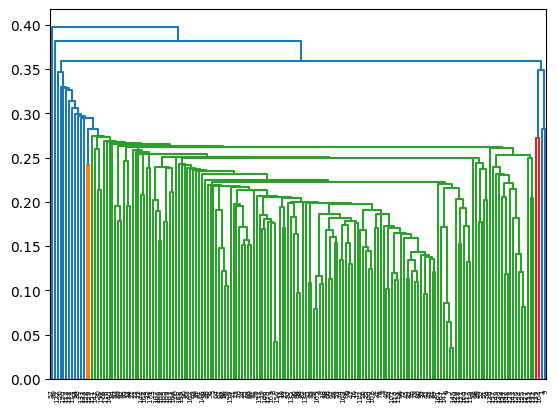

In [19]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

dendrogram(linkage_matrix)
plt.rcParams["figure.figsize"] = (32, 18)
plt.show()

As you can see with the blue color samples, they get left behind with this bottom-up approach. They are only clustered when the clustering of the green samples are finished. This becomes problematic when we call `fcluster` from scipy, which only has two main criteria for selecting clusters:
- `distance`: A horizontal threshold line on the dendrogram. Because the blue samples are left behind, no matter where we set the threshold, you can clearly see these samples will become standalone because they only get grouped together later, not earlier.
- `maxclust`: The number of clusters. `fcluster` only selects clusters AFTER the linkage matrix is already formed, instead of BEFORE. Therefore, it selects clusters to meet the `maxclust` requirement with a top-down approach. Because the blue samples are left behind, no matter how many clusters we set, they will be left out. For example, if we set `n_clusters=2`, then `57` becomes its own cluster, and all other samples are grouped together:

In [20]:
texts, ids = cluster_chunker_k_split(doc_attention, doc_id="doc0", n_clusters=2)
log_clusters(texts, ids)

doc0|1 Attention Is All You Need
Abstract
The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder.
The best performing models also connect the encoder and decoder through an attention mechanism.
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train.
Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU.
On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models fro

Therefore, for semantic chunking where the chunk size matters, we CANNOT rely on the `linkage` matrix in SciPy.

My implementation is simple. We iterate through the distance matrix by looking at the minimal distance between 2 points at each step. If the sample size of the combination of the 2 clusters which each point belongs to is less than or equal to the `max_sample_per_cluster` threshold, then link them. Else, don't link them.

This implementation ensures:
1) A stable and balanced cluster size for all samples
2) Still looking at the minimal distance at each step

I cannot draw a dendrogram with my implementation because
1) `linkage` creates new cluster IDs while my implementation uses sample IDs as cluster IDs.
2) I do not create a linkage matrix.

But you could obviously see the difference in the output chunks above. The dendrogram should have been evenly distributed.

Let's look at the dendrogram of the old clustering method on the sampled MLDR and BEIR document as well:

MLDR

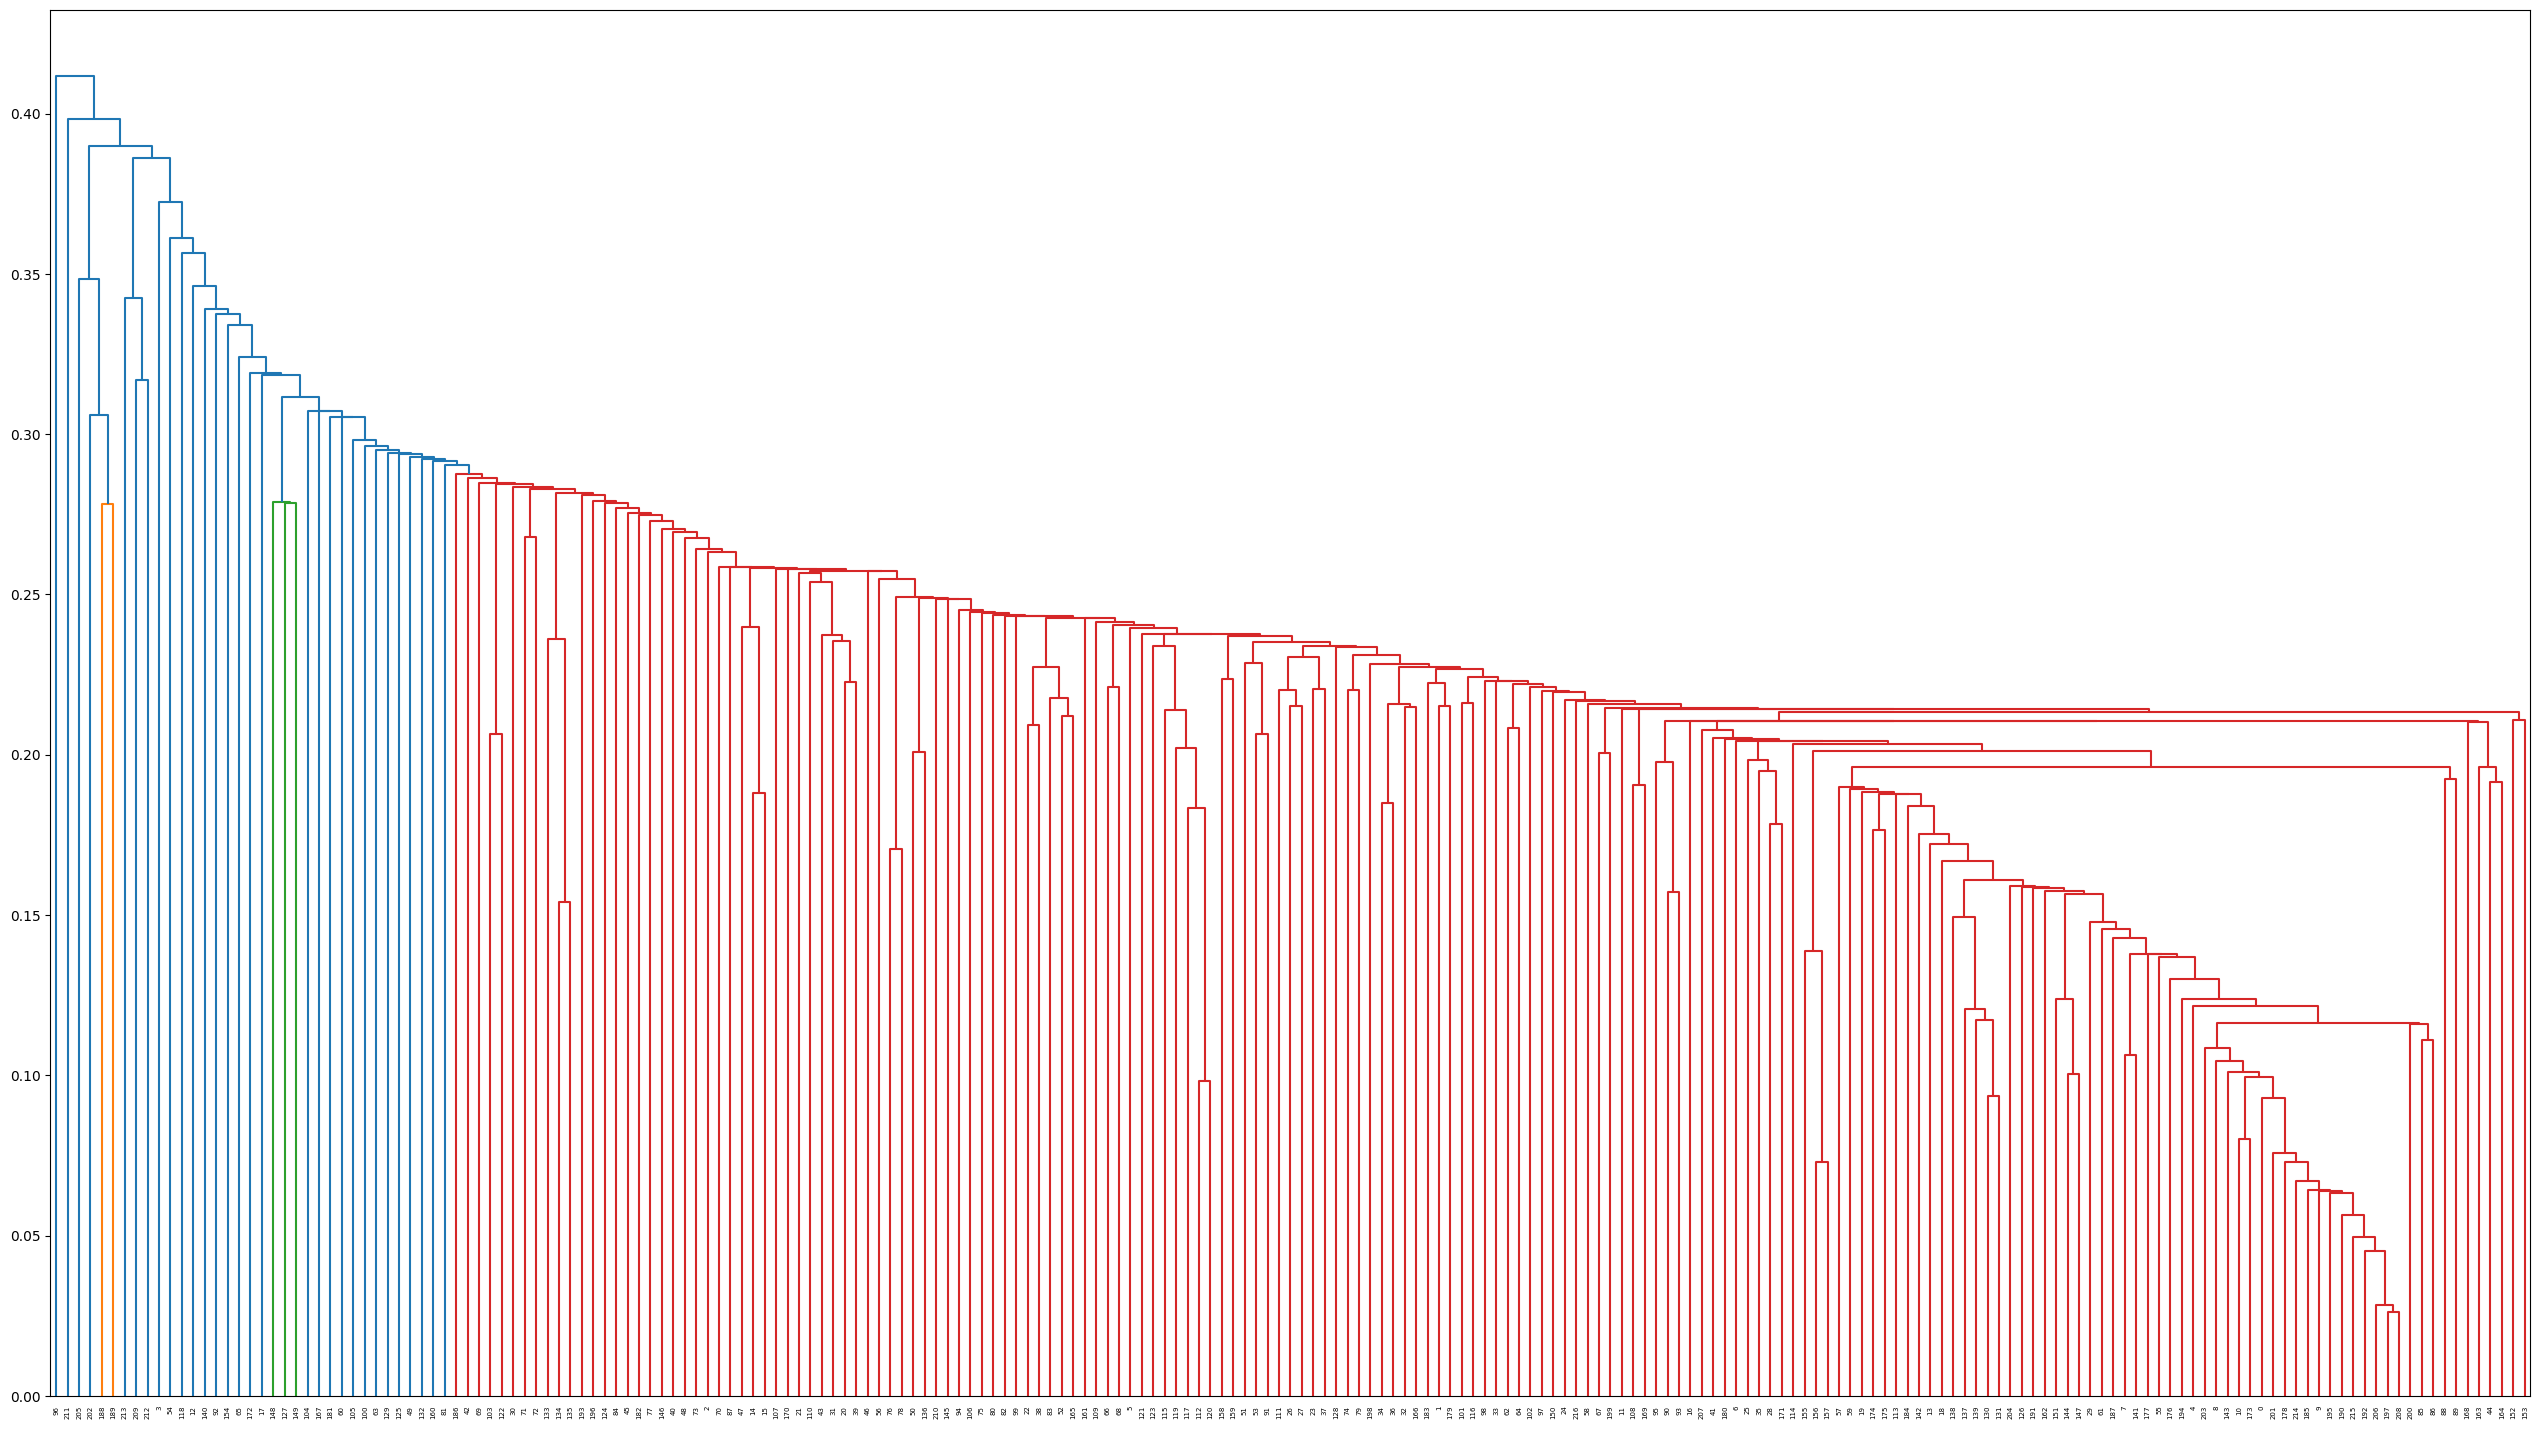

In [21]:
sents = split_sentences(doc_mldr)
embs = model.encode(sents)
metric = partial(__dist__, n_segments=len(embs), lamda=0)
distance_matrix = np.abs(pdist(embs, metric=metric))
linkage_matrix = linkage(distance_matrix, method='single')
dendrogram(linkage_matrix)
plt.rcParams["figure.figsize"] = (32, 18)
plt.show()

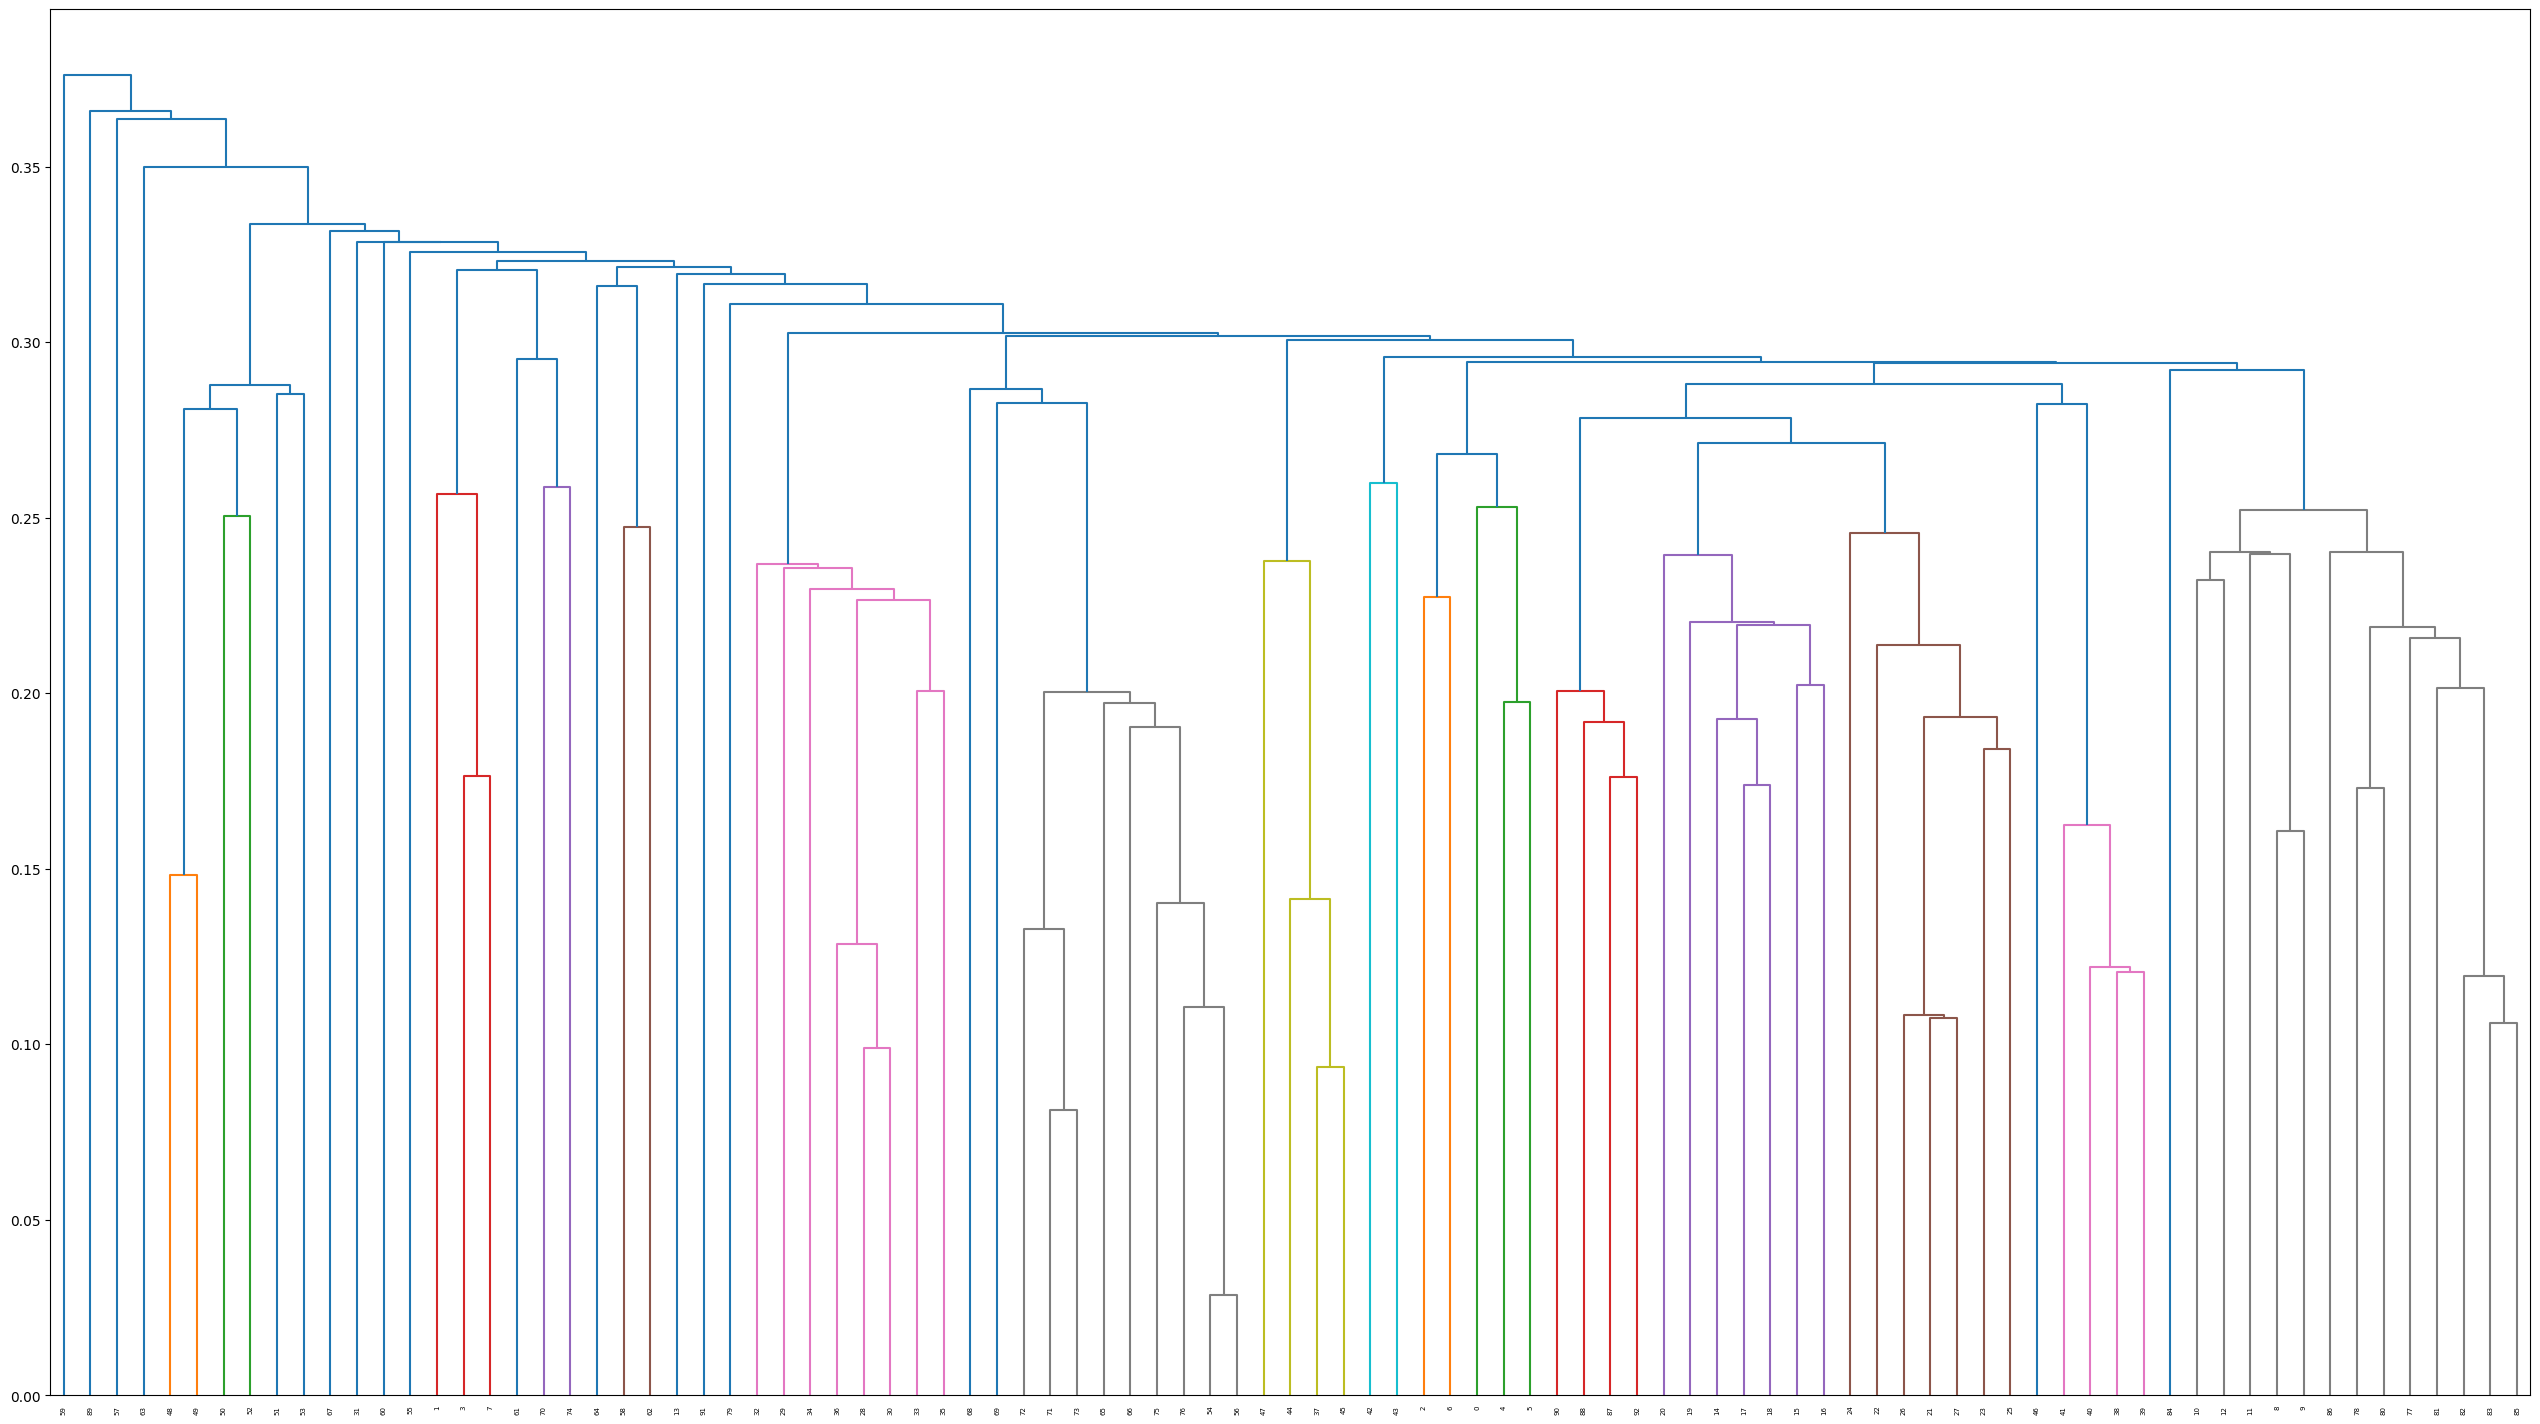

In [22]:
sents = split_sentences(doc_beir)
embs = model.encode(sents)
metric = partial(__dist__, n_segments=len(embs), lamda=0)
distance_matrix = np.abs(pdist(embs, metric=metric))
linkage_matrix = linkage(distance_matrix, method='single')
dendrogram(linkage_matrix)
plt.rcParams["figure.figsize"] = (32, 18)
plt.show()